<a href="https://colab.research.google.com/github/SantonioTheFirst/DataAnalysis/blob/main/lab5/Synthetic_seq2seq.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [27]:
import tensorflow
from tensorflow import keras
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt

import numpy as np
import random

In [53]:
n_timesteps_in = 70
n_timesteps_out = 35

n_features_in = 1
n_features_out = 1

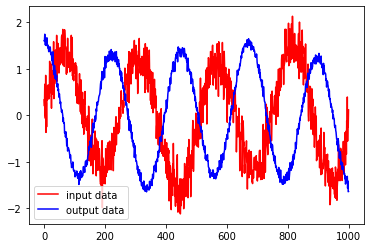

In [54]:
time_series_length = 1000
t = np.linspace(0, 10, time_series_length)
ts_input = np.sin(t) / 3.2 + 1.8 * np.sin(t * 2.5) + 0.4 * np.random.standard_normal(size=time_series_length)
ts_output = np.cos(t) / 2.6 + 3 * np.cos(t * 2.8) + 0.15 * np.random.standard_normal(size=time_series_length)


ts_norm_input = (ts_input - np.mean(ts_input)) / np.std(ts_input)
ts_norm_output = (ts_output - np.mean(ts_output)) / np.std(ts_output)
plt.plot(ts_norm_input, 'r', label = 'input data')
plt.plot(ts_norm_output,'b', label = 'output data')

plt.legend()

In [55]:
train_size = int(len(ts_input) * 0.8)
test_size = len(ts_input) - train_size

train_input, test_input = ts_norm_input[0:train_size], ts_norm_input[train_size:len(ts_input)]
train_output, test_output = ts_norm_output[0:train_size], ts_norm_output[train_size:len(ts_input)]

In [56]:
seq_len = max(n_timesteps_in, n_timesteps_out)
def create_dataset():
    # train data
    train_input_data, train_output_data = [], []
    for i in range(500):
        rand_ind_train = random.randint(0, len(train_input) - seq_len)
        input_seq = ts_norm_input[rand_ind_train:rand_ind_train+n_timesteps_in]
        output_seq = ts_norm_output[rand_ind_train:rand_ind_train+n_timesteps_out]
        train_input_data.append(input_seq)
        train_output_data.append(output_seq)
    # test data
    test_input_data, test_output_data = [], []   
    for i in range(5):
        rand_ind_test = random.randint(0, len(test_input) - seq_len)
        input_seq = ts_norm_input[rand_ind_test:rand_ind_test+n_timesteps_in]
        output_seq = ts_norm_output[rand_ind_test:rand_ind_test+n_timesteps_out]
        test_input_data.append(input_seq)
        test_output_data.append(output_seq)
    return np.array(train_input_data), np.array(train_output_data), np.array(test_input_data), np.array(test_output_data)

In [57]:
train_input_data, train_output_data, test_input_data, test_output_data = create_dataset()

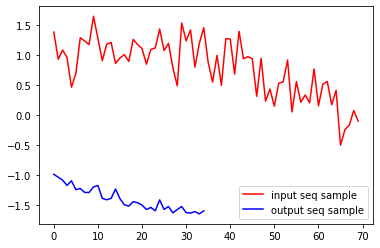

In [58]:
plt.plot(train_input_data[0], 'r', label = 'input seq sample')
plt.plot(train_output_data[0], 'b', label = 'output seq sample')
plt.legend()

In [59]:
train_input_data = np.reshape(train_input_data, (train_input_data.shape[0], n_timesteps_in, n_features_in))
train_output_data = np.reshape(train_output_data, (train_input_data.shape[0], n_timesteps_out, n_features_out))

test_input_data = np.reshape(test_input_data, (test_input_data.shape[0], n_timesteps_in, n_features_in))
test_output_data = np.reshape(test_output_data, (test_input_data.shape[0], n_timesteps_out, n_features_out))

In [60]:
n_units = 128

encoder_inputs = keras.Input(shape=(n_timesteps_in, n_features_in))
encoder = keras.layers.LSTM(n_units, return_sequences=False, return_state=True)
encoder_outputs, state_h, state_c = encoder(encoder_inputs)

encoder_states = [state_h, state_c]

decoder_inputs = keras.Input(shape=(n_timesteps_out, n_features_out))
decoder_lstm =  keras.layers.LSTM(n_units, return_sequences=True, return_state=True)

decoder_outputs, _, _ = decoder_lstm(decoder_inputs, initial_state=encoder_states)
decoder_dense = keras.layers.Dense(n_features_out, activation='linear')
decoder_outputs = decoder_dense(decoder_outputs)

model = keras.Model([encoder_inputs, decoder_inputs], decoder_outputs)

In [61]:
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

In [62]:
decoder_inputs = np.zeros(train_output_data.shape)
es = EarlyStopping(patience=5, restore_best_weights=True, min_delta=0.001)

history = model.fit([train_input_data, decoder_inputs], train_output_data,
          epochs=100, batch_size=128, validation_split=0.2, callbacks=[es])

Epoch 1/100
4/4 [==============================] - 5s 363ms/step - loss: 1.0108 - mae: 0.9029 - val_loss: 1.0147 - val_mae: 0.8899
Epoch 2/100
4/4 [==============================] - 0s 48ms/step - loss: 0.9917 - mae: 0.8935 - val_loss: 1.0043 - val_mae: 0.8832
Epoch 3/100
4/4 [==============================] - 0s 48ms/step - loss: 0.9771 - mae: 0.8864 - val_loss: 0.9767 - val_mae: 0.8740
Epoch 4/100
4/4 [==============================] - 0s 48ms/step - loss: 0.9534 - mae: 0.8764 - val_loss: 0.8533 - val_mae: 0.8198
Epoch 5/100
4/4 [==============================] - 0s 48ms/step - loss: 0.7773 - mae: 0.7670 - val_loss: 0.5084 - val_mae: 0.5948
Epoch 6/100
4/4 [==============================] - 0s 49ms/step - loss: 0.5101 - mae: 0.6177 - val_loss: 0.5496 - val_mae: 0.6307
Epoch 7/100
4/4 [==============================] - 0s 47ms/step - loss: 0.4614 - mae: 0.5568 - val_loss: 0.3922 - val_mae: 0.5226
Epoch 8/100
4/4 [==============================] - 0s 47ms/step - loss: 0.3812 - mae: 0.4

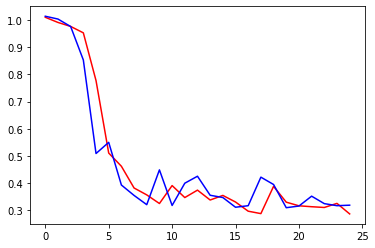

In [63]:
plt.plot(history.history['loss'], color='r')
plt.plot(history.history['val_loss'], color='b')
plt.show()

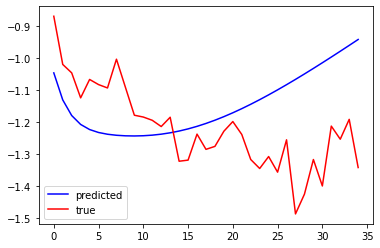

In [65]:
decoder_inputs = np.zeros(test_output_data.shape)
y_pred = model.predict([test_input_data, decoder_inputs])

plt.plot(y_pred[0], 'b', label = 'predicted')
plt.plot(test_output_data[0], 'r', label = 'true')
plt.legend()
plt.show()